#Softmax regression implemetation
implemented using numpy, used to predict MNIST labels.

In [5]:
from sys import maxsize
import matplotlib.pyplot as plt
import numpy as np

# initial constants
WEIGHTS_SIZE=784
EPOCHS=500
LR=0.00002
EPSILON=1e-6
LABELS_SIZE=10


In [6]:
# Utility functions

def one_hot_encode(labels):
  """
    One hot encode labels 3=>[0,0,0,1,0,0,0,0,0,0]
  """
  one_hot_encoded=np.zeros((labels.size,LABELS_SIZE))
  one_hot_encoded[np.arange(labels.size),labels]=1

  return one_hot_encoded

def get_error_count(labels,logits):
  """
    get error count true labels and the softmax logits
  """
  return (np.ones(logits.shape)[logits==np.argmax(labels,axis=1)].sum())/logits.shape[0]

def format_percent(num,denom):
  """
    format percentage for printing the predictions
    send numerator denominator get the percentage
  """
  frac=num/denom if denom!=0 else 1
  return '{0:.2f}'.format(frac*100 if frac<=1 and frac>=0 else frac)

In [7]:
def softmax(z):
    """
    calculate softmax activation result for given vector z
    """
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis]
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]
    return e_x / div

def gradient(features,one_hot_labels,preds):
  """
   gradient function for softmax
  """
  return -(np.dot(features.T,(one_hot_labels-preds)).T)

In [8]:
class SoftmaxRegression:

  def __init__(self,X_train,y_train,X_test,y_test,epochs=EPOCHS,lr=LR):
    self.X_train=X_train
    self.y_train=y_train
    self.X_test=X_test
    self.y_test=y_test
    # Init weights and bias vector list
    self.weights=np.array([np.concatenate(([0], np.random.rand(WEIGHTS_SIZE))) for i in range(10)])
    # Keep track model losses in training to plot a loss curve
    self.losses=[]
    self.accuracies=[]
    # Init number of epochs and learning rate
    self.epochs=epochs
    self.lr=lr


  def train(self):
    for epoch in range(1,self.epochs+1):

      # Use the model to predict
      preds=softmax(np.dot(self.X_train,self.weights.T))
      # Update the weights using Gradient Descent
      self.weights-=self.lr*gradient(self.X_train,self.y_train,preds)
      # Calculate model's loss using Cross Entropy
      loss=self.loss(preds,self.y_train)

      # Evaluate the model on the test data
      # Predict test samples
      test_preds=softmax(np.dot(self.X_test,self.weights.T))
      # Calculate model's loss on test data
      test_loss=self.loss(test_preds,self.y_test)

      # Calculate label predictions
      train_labels=np.argmax(preds,axis=1)
      test_labels=np.argmax(test_preds,axis=1)

      # Calculate train and test accuracies
      train_accuracy=get_error_count(self.y_train,train_labels)
      test_accuracy=get_error_count(self.y_test,test_labels)

      # train_accuracy=(np.ones(train_labels.shape)[train_labels==np.argmax(self.y_train,axis=1)].sum())/train_labels.shape[0]
      # test_accuracy=(np.ones(test_labels.shape)[test_labels==np.argmax(self.y_test,axis=1)].sum())/test_labels.shape[0]
          # return (np.ones(logits.shape)[logits==labels].sum())/logits.shape[0]


      if epoch%10==0:
        print(f"Epoch:{epoch}\t|\tTrain loss:{loss}\t|\tTest loss:{test_loss}\t|\tTrain accuracy:{format_percent(train_accuracy,1)}%\t|\tTest accuracy:{format_percent(test_accuracy,1)}%")
      self.losses.append((loss,test_loss))
      self.accuracies.append((train_accuracy,test_accuracy))

      # Stop training if accuracy delta is smaller than EPSILON
      try:
        self.accuracies[-2]
      except IndexError:
        pass
      else:
        if abs(self.accuracies[-2][0]-self.accuracies[-1][0])<EPSILON:
          return

  def loss(self, preds, true):
      """
      Compute the loss using cross entropy
      """
      max_preds_y=np.max(preds*true,axis=1)

      # sum the loss over the batch size
      sum_error=-np.sum(np.log(max_preds_y[max_preds_y!=0]))
      loss=sum_error/preds.shape[0]
      return loss

  def predict(self,x):
    """
    Predict labels for given X vector
    """
    return np.argmax(softmax(np.dot(x,self.weights.T)),axis=1)

  def plot_loss_curve(self):
    figure,axis=plt.subplots(2)

    self.losses=np.array(self.losses)
    self.accuracies=np.array(self.accuracies)

    axis[0].set_title("loss over iterations")
    axis[0].set_xlim(1,len(self.losses))
    axis[0].plot(np.array(self.losses)[:,0], linestyle='solid', color='b', label='Train loss')
    axis[0].plot(np.array(self.losses)[:,1], linestyle='solid', color='r', label='Test loss')
    axis[0].legend()

    axis[1].set_title("accuracy over iterations")
    axis[1].set_ylim(0,1)
    axis[1].set_xlim(1,len(self.accuracies))
    axis[1].plot(np.array(self.accuracies)[:,0], linestyle='solid', color='b', label='Train accuracy')
    axis[1].plot(np.array(self.accuracies)[:,1], linestyle='solid', color='r', label='Test accuracy')
    axis[1].legend()
    plt.show()

  def compute_confusion_mat(self):
      """
      Compute and print the confusion matrixes on test data
      """
      test_label_preds = self.predict(self.X_test)
      zipped=list(zip(test_label_preds, np.argmax(self.y_test,axis=1)))
      # Confusion matrix for each classifier
      for i in range(len(self.weights)):
          tn = len(list(filter(lambda l: l[0] != i and l[1] != i, zipped)))
          fn = len(list(filter(lambda l: l[0] == i and l[1] != i, zipped)))
          tp = len(list(filter(lambda l: l[0] == i and l[1] == i, zipped)))
          fp = len(list(filter(lambda l: l[0] != i and l[1] == i, zipped)))

          print("------------------------------------------------------------------------------------------------------------------")
          print(f"--------\tConfusion Matrix for digit {i}\t--------")
          print("------------------------------------------------------------------------------------------------------------------")
          print("\t|\tTrue\t|\tFalse")
          print("---------------------------------------------")
          print(f"Positive|\t{tp}\t|\t{fp}")
          print(f"Negative|\t{tn}\t|\t{fn}")
          print("------------------------------------------------------------------------------------------------------------------")
          print(f"Accuracy: {format_percent(tp+tn,tp+tn+fp+fn)}\t|\tSensitivity: {format_percent(tp,tp+fn)}\t|\tSelectivity: {format_percent(tn,tn+fp)}")
          print("------------------------------------------------------------------------------------------------------------------\n\n")

      # Compute confusion matrix for multi label model
      confusion_matrix = [[0] * len(self.weights) for _ in range(len(self.weights))]
      for true_label, predicted_label in zipped:
          confusion_matrix[predicted_label][true_label] += 1
      # Print matrix
      print("Confusion Matrix:")
      print("Predicted\Actual", end="\t")
      for i in range(len(confusion_matrix)):
          print(f"Digit {i}", end="\t")
      print()

      for i in range(len(confusion_matrix)):
          print(f"Digit {i}", end="\t\t\t")
          for j in range(len(confusion_matrix[i])):
              print(confusion_matrix[i][j], end="\t")
          print()

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
WEIGHTS_SIZE=784

# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')
# Access features (pixel values) and labels
X, y = mnist['data'], mnist['target']

# Convert X,y to numpy arrays and normalize X
X, y = X.to_numpy(dtype=float)/255, y.to_numpy(dtype=int)

# One hot encode y
y = one_hot_encode(y)

# Append 1 to each sample for the bias
X = np.array(list(map(lambda sample: np.append([1], sample), X)))

# Split dataset into train and test sets 60k train and 10k test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 / 7)


In [10]:
s=SoftmaxRegression(X_train,y_train,X_test,y_test)
s.train()

Epoch:10	|	Train loss:1.3459070716581896	|	Test loss:1.1229194994760354	|	Train accuracy:66.16%	|	Test accuracy:70.43%
Epoch:20	|	Train loss:0.7003858827360053	|	Test loss:0.6992460938116827	|	Train accuracy:77.69%	|	Test accuracy:78.13%
Epoch:30	|	Train loss:0.5300089361312065	|	Test loss:0.5245038248812199	|	Train accuracy:83.82%	|	Test accuracy:84.21%
Epoch:40	|	Train loss:0.4891562479193678	|	Test loss:0.48580621496484816	|	Train accuracy:85.22%	|	Test accuracy:85.27%
Epoch:50	|	Train loss:0.45683707621418107	|	Test loss:0.4548680330056597	|	Train accuracy:86.37%	|	Test accuracy:86.35%
Epoch:60	|	Train loss:0.43345506479889484	|	Test loss:0.43326364990459454	|	Train accuracy:87.12%	|	Test accuracy:86.97%
Epoch:70	|	Train loss:0.4172072683003734	|	Test loss:0.418073146244945	|	Train accuracy:87.68%	|	Test accuracy:87.49%
Epoch:80	|	Train loss:0.4045303771453065	|	Test loss:0.4061382169932373	|	Train accuracy:88.09%	|	Test accuracy:87.91%
Epoch:90	|	Train loss:0.3940648443769657	|	Te

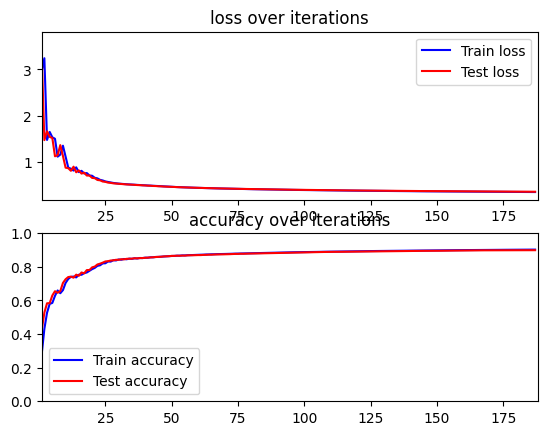

In [11]:
s.plot_loss_curve()

In [12]:
s.compute_confusion_mat()

------------------------------------------------------------------------------------------------------------------
--------	Confusion Matrix for digit 0	--------
------------------------------------------------------------------------------------------------------------------
	|	True	|	False
---------------------------------------------
Positive|	975	|	50
Negative|	8923	|	52
------------------------------------------------------------------------------------------------------------------
Accuracy: 98.98	|	Sensitivity: 94.94	|	Selectivity: 99.44
------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------
--------	Confusion Matrix for digit 1	--------
------------------------------------------------------------------------------------------------------------------
	|	True	|	False
---------------------------------------


# Conclusion

as i look at the confusion tables for each classifier each has a great accuracy and selectivity meters, two classifiers stood out with quite low sensitivity meter on both the digits **8** and **9**.
from the confusion matrix for all classifiers i can see that it has a lot of mistakes on those two digits - it hasn't learned it as well as the other digits at **8** it had a lot of fn on the digit **2** and on **5** it had a lot of fn on the digit **3**. i think that i would use this classifier for all the digits and if it's either one of 5 or 8 i would transfer it to human examination.
to the most part the learning converged i think these are nice results.